In [2]:
import os
import math
import time
import argparse
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss, Module
from torch.optim.lr_scheduler import ExponentialLR
from torchmetrics import AUROC, Accuracy, MeanSquaredError
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

from torch_frame import stype
from torch_frame.data import Dataset, DataLoader
from torch_frame.datasets import (
    ForestCoverType, KDDCensusIncome, DataFrameBenchmark,
    AdultCensusIncome, BankMarketing, Dota2
)
from torch_frame.gbdt import CatBoost, LightGBM, XGBoost
from torch_frame.nn import (
    EmbeddingEncoder, FTTransformer, LinearBucketEncoder,
    LinearEncoder, LinearPeriodicEncoder, ResNet, TabNet, TabTransformer
)
from torch_frame.nn.models import (
    MLP, ExcelFormer, Trompt
)
from torch_frame.typing import TaskType



# Use GPU for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_csv("thyroid_cancer_risk_data.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212691 entries, 0 to 212690
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Patient_ID           212691 non-null  int64  
 1   Age                  212691 non-null  int64  
 2   Gender               212691 non-null  object 
 3   Country              212691 non-null  object 
 4   Ethnicity            212691 non-null  object 
 5   Family_History       212691 non-null  object 
 6   Radiation_Exposure   212691 non-null  object 
 7   Iodine_Deficiency    212691 non-null  object 
 8   Smoking              212691 non-null  object 
 9   Obesity              212691 non-null  object 
 10  Diabetes             212691 non-null  object 
 11  TSH_Level            212691 non-null  float64
 12  T3_Level             212691 non-null  float64
 13  T4_Level             212691 non-null  float64
 14  Nodule_Size          212691 non-null  float64
 15  Thyroid_Cancer_Ri

In [5]:
df = df.drop(columns=["Patient_ID"])

# AutoEncoder

In [16]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded  # Bottleneck layer 값 반환

In [17]:
# Target은 AutoEncoder X
X_only = df.drop(columns=["Diagnosis"])

# continuous만 적용 예정
continuous_vars = X_only.select_dtypes(include=["int64", "float64"]).columns
categorical_vars = X_only.select_dtypes(include=["object"]).columns

# 모델 생성
input_dim = X_only[continuous_vars].shape[1]  # Feature 개수
hidden_dim = input_dim  # 축소 후 차원 (이 크기의 절반이 새로 만들어진 feature의 수)
autoencoder = Autoencoder(input_dim, hidden_dim)

# PyTorch 텐서 변환
X_tensor = torch.tensor(X_only[continuous_vars].values, dtype=torch.float32)

# Optimizer & Loss 설정
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.01)

In [18]:
# 학습
for epoch in range(50):
    optimizer.zero_grad()
    decoded, encoded = autoencoder(X_tensor)  # Bottleneck feature 추출
    loss = criterion(decoded, X_tensor)  # ✅ 디코더 출력과 원본 데이터 비교
    loss.backward()
    optimizer.step()


# Bottleneck feature 추출 (차원 축소된 데이터)
_, X_reduced = autoencoder(X_tensor)
X_reduced = X_reduced.detach().numpy()

# 👉 변환된 Feature를 DataFrame으로 변환
df_reduced = pd.DataFrame(X_reduced, index=df.index, columns=[f"reduced_{i}" for i in range(X_reduced.shape[1])])

# 🎯 원래 Target(y) 컬럼을 붙여서 최종 DataFrame 생성
df_AE = pd.concat([df[categorical_vars], df_reduced, df["Diagnosis"]], axis=1)

In [19]:
df_AE.head()

,Gender,Country,Ethnicity,Family_History,Radiation_Exposure,Iodine_Deficiency,Smoking,Obesity,Diabetes,Thyroid_Cancer_Risk,reduced_0,reduced_1,Diagnosis
0,Male,Russia,Caucasian,No,Yes,No,No,No,No,Low,14.261535,14.143646,Benign
1,Male,Germany,Hispanic,No,Yes,No,No,No,No,Low,6.360524,6.536441,Benign
2,Male,Nigeria,Caucasian,No,No,No,No,No,No,Low,17.416933,17.181707,Benign
3,Female,India,Asian,No,No,No,No,No,No,Medium,14.630919,14.499295,Benign
4,Female,Germany,African,Yes,Yes,No,No,No,No,High,9.049031,9.124974,Benign


In [20]:
df_AE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212691 entries, 0 to 212690
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Gender               212691 non-null  object 
 1   Country              212691 non-null  object 
 2   Ethnicity            212691 non-null  object 
 3   Family_History       212691 non-null  object 
 4   Radiation_Exposure   212691 non-null  object 
 5   Iodine_Deficiency    212691 non-null  object 
 6   Smoking              212691 non-null  object 
 7   Obesity              212691 non-null  object 
 8   Diabetes             212691 non-null  object 
 9   Thyroid_Cancer_Risk  212691 non-null  object 
 10  reduced_0            212691 non-null  float32
 11  reduced_1            212691 non-null  float32
 12  Diagnosis            212691 non-null  object 
dtypes: float32(2), object(11)
memory usage: 19.5+ MB


# ML

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
import catboost as cb
import xgboost as xgb
from sklearn.model_selection import cross_val_score

In [28]:
# Alzheimer’s Diagnosis를 종속 변수(y)로 설정
y_col = "Diagnosis"
y = df_AE[y_col]

# 독립 변수(X) 설정 (Patient_ID 제거)
X = df_AE.drop(columns=[y_col, "Country"])

# 연속형 변수 (float, int)와 범주형 변수 분리
continuous_vars = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_vars = X.select_dtypes(include=["object"]).columns.tolist()

df_encoded = pd.get_dummies(df_AE, columns=categorical_vars)
X = df_encoded.drop(columns=[y_col, "Country"])

In [29]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
from sklearn.preprocessing import LabelEncoder

# Label Encoding 수행
le = LabelEncoder()
y_train = le.fit_transform(y_train)  # 'Benign' -> 0, 'Malignant' -> 1
y_test = le.transform(y_test)  

## Model

### Logistic Regression

In [31]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
log_acc = accuracy_score(y_test, y_pred_log)
print(f'Logistic Regression Accuracy: {log_acc:.4f}')

Logistic Regression Accuracy: 0.8251


### Random Forest

In [32]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {rf_acc:.4f}')

Random Forest Accuracy: 0.7227


### Decision Tree

In [33]:
dt_params = {'max_depth': [3, 5, 10, 15, None]}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='accuracy')
dt_grid.fit(X_train, y_train)
dt_best = dt_grid.best_estimator_

y_pred_dt = dt_best.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)

print("🔹 Decision Tree Results:")
print("Best Parameters:", dt_grid.best_params_)
print("Accuracy:", acc_dt)
print(classification_report(y_test, y_pred_dt))

🔹 Decision Tree Results:
Best Parameters: {'max_depth': 3}
Accuracy: 0.825007640047956
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     32615
           1       0.69      0.45      0.54      9924

    accuracy                           0.83     42539
   macro avg       0.77      0.69      0.72     42539
weighted avg       0.81      0.83      0.81     42539



### XGBoost

In [34]:
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print("🔹 XGBoost Classifier Results:")
print("Accuracy:", acc_xgb)
print(classification_report(y_test, y_pred_xgb))

/opt/conda/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [07:07:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔹 XGBoost Classifier Results:
Accuracy: 0.825007640047956
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     32615
           1       0.69      0.45      0.54      9924

    accuracy                           0.83     42539
   macro avg       0.77      0.69      0.72     42539
weighted avg       0.81      0.83      0.81     42539



### LightGBM

In [35]:
lgb_model = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, learning_rate=0.05, 
                                 n_estimators=200, force_col_wise=True, random_state=42)
lgb_model.fit(X_train, y_train)

y_pred_lgb = lgb_model.predict(X_test)

print("🔹 LightGBM Model Performance 🔹")
print("Accuracy:", accuracy_score(y_test, y_pred_lgb))
print(classification_report(y_test, y_pred_lgb))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 39571, number of negative: 130581
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 170152, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.232563 -> initscore=-1.193897
[LightGBM] [Info] Start training from score -1.193897
🔹 LightGBM Model Performance 🔹
Accuracy: 0.8250546557276852
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     32615
           1       0.69      0.45      0.54      9924

    accuracy                           0.83     42539
   macro avg       0.77      0.69      0.72     42539
weighted avg       0.81      0.83      0.81     42539



### CatBoost

In [36]:
cat_model = cb.CatBoostClassifier(iterations=200, depth=6, learning_rate=0.05, loss_function='Logloss', verbose=0, random_seed=42)
cat_model.fit(X_train, y_train)

y_pred_cat = cat_model.predict(X_test)

print("🔹 CatBoost Model Performance 🔹")
print("Accuracy:", accuracy_score(y_test, y_pred_cat))
print(classification_report(y_test, y_pred_cat))

🔹 CatBoost Model Performance 🔹
Accuracy: 0.8250546557276852
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     32615
           1       0.69      0.45      0.54      9924

    accuracy                           0.83     42539
   macro avg       0.77      0.69      0.72     42539
weighted avg       0.81      0.83      0.81     42539



# DL

In [40]:
df_AE = df_AE.drop(columns=["Country"])

KeyError: "['Country'] not found in axis"

In [41]:
# 분류 task
is_classification = True

In [42]:
from torch_frame import numerical, categorical, text_embedded, embedding

## 칼럼 별 Dtype 지정 
col_to_stype={"Gender" : categorical,
              "Ethnicity" : categorical,
              "Family_History" : categorical,
              "Radiation_Exposure" : categorical,
              "Iodine_Deficiency" : categorical,
              "Smoking" : categorical,
              "Obesity" : categorical,
              "Diabetes" : categorical,
              "Thyroid_Cancer_Risk" : categorical,
              "Diagnosis" : categorical,
              "reduced_0" : numerical,
              "reduced_1" : numerical}

dataset = Dataset(df = df_AE, 
                  col_to_stype = col_to_stype, 
                  target_col = "Diagnosis")

dataset.materialize()

## split
train_dataset, val_dataset, test_dataset = dataset[:0.6], dataset[0.6:0.7], dataset[0.7:]

### ResNet

In [43]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='adult')
parser.add_argument('--numerical_encoder_type', type=str, default='linear',
                    choices=['linear', 'linearbucket', 'linearperiodic'])
parser.add_argument('--model_type', type=str, default='fttransformer',
                    choices=['fttransformer', 'resnet'])
parser.add_argument('--channels', type=int, default=256)
parser.add_argument('--num_layers', type=int, default=4)
parser.add_argument('--batch_size', type=int, default=512)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

_StoreTrueAction(option_strings=['--compile'], dest='compile', nargs=0, const=True, default=False, type=None, choices=None, required=False, help=None, metavar=None)

In [44]:
# Jupyter에서 실행될 때는 sys.argv를 조정
args = parser.parse_args([
    #'--dataset', 'adult',
    '--numerical_encoder_type', 'linear',
    '--model_type', 'resnet',       # fttransformer : FT-T / resnet : ResNet
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [45]:
# Set up data loaders
train_tensor_frame = train_dataset.tensor_frame
val_tensor_frame = val_dataset.tensor_frame
test_tensor_frame = test_dataset.tensor_frame
train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                          shuffle=True)
val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)

if args.numerical_encoder_type == 'linear':
    numerical_encoder = LinearEncoder()
elif args.numerical_encoder_type == 'linearbucket':
    numerical_encoder = LinearBucketEncoder()
elif args.numerical_encoder_type == 'linearperiodic':
    numerical_encoder = LinearPeriodicEncoder()
else:
    raise ValueError(
        f'Unsupported encoder type: {args.numerical_encoder_type}')

stype_encoder_dict = {
    stype.categorical: EmbeddingEncoder(),
    stype.numerical: numerical_encoder,
}

if is_classification:
    #output_channels = dataset.num_classes    ->   contains StatType.COUNT을 포함하지 않아서 오류(?)
    output_channels = 2 # 그냥 수동으로 설정.,,,,   => 분류 칼럼 unique 개수로 설정 
else:
    output_channels = 1

In [46]:
if args.model_type == 'fttransformer':
    model = FTTransformer(
        channels=args.channels,
        out_channels=output_channels,
        num_layers=args.num_layers,
        col_stats=dataset.col_stats,    # TensorFrame이 col_stats를 안받아서 transor frame으로 바꾸기 전으로 받아와야 함 
        col_names_dict=train_tensor_frame.col_names_dict,
        stype_encoder_dict=stype_encoder_dict,
    ).to(device)

elif args.model_type == 'resnet':
    model = ResNet(
        channels=args.channels,
        out_channels=output_channels,
        num_layers=args.num_layers,
        col_stats=dataset.col_stats,
        col_names_dict=train_tensor_frame.col_names_dict,
    ).to(device)
else:
    raise ValueError(f'Unsupported model type: {args.model_type}')

model = torch.compile(model, dynamic=True) if args.compile else model
optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)

In [47]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            loss = F.cross_entropy(pred, tf.y.long())
        else:
            loss = F.mse_loss(pred.view(-1), tf.y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse


In [48]:
# 훈련 및 테스트

if is_classification:
    metric = 'Acc'
    best_val_metric = 0
    best_test_metric = 0
else:
    metric = 'RMSE'
    best_val_metric = float('inf')
    best_test_metric = float('inf')

for epoch in range(1, args.epochs + 1):
    train_loss = train(epoch)
    train_metric = test(train_loader)
    val_metric = test(val_loader)
    test_metric = test(test_loader)

    if is_classification and val_metric > best_val_metric:
        best_val_metric = val_metric
        best_test_metric = test_metric
    elif not is_classification and val_metric < best_val_metric:
        best_val_metric = val_metric
        best_test_metric = test_metric

    print(f'Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
          f'Val {metric}: {val_metric:.4f}, Test {metric}: {test_metric:.4f}')

print(f'Best Val {metric}: {best_val_metric:.4f}, '
      f'Best Test {metric}: {best_test_metric:.4f}')


Epoch: 1: 100%|██████████| 499/499 [00:10<00:00, 48.15it/s] 


Train Loss: 0.4586, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 2: 100%|██████████| 499/499 [00:06<00:00, 74.84it/s]


Train Loss: 0.4541, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 3: 100%|██████████| 499/499 [00:07<00:00, 71.09it/s]


Train Loss: 0.4530, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 4: 100%|██████████| 499/499 [00:06<00:00, 78.89it/s] 


Train Loss: 0.4526, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 5: 100%|██████████| 499/499 [00:06<00:00, 82.14it/s] 


Train Loss: 0.4525, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 6: 100%|██████████| 499/499 [00:06<00:00, 81.50it/s] 


Train Loss: 0.4523, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 7: 100%|██████████| 499/499 [00:05<00:00, 92.48it/s] 


Train Loss: 0.4523, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 8: 100%|██████████| 499/499 [00:06<00:00, 79.44it/s]


Train Loss: 0.4523, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 9: 100%|██████████| 499/499 [00:06<00:00, 78.15it/s] 


Train Loss: 0.4521, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 10: 100%|██████████| 499/499 [00:05<00:00, 84.46it/s] 


Train Loss: 0.4521, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 11: 100%|██████████| 499/499 [00:06<00:00, 78.85it/s] 


Train Loss: 0.4521, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 12: 100%|██████████| 499/499 [00:05<00:00, 85.88it/s] 


Train Loss: 0.4521, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 13: 100%|██████████| 499/499 [00:06<00:00, 80.01it/s] 


Train Loss: 0.4520, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 14: 100%|██████████| 499/499 [00:04<00:00, 101.87it/s]


Train Loss: 0.4519, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 15: 100%|██████████| 499/499 [00:06<00:00, 82.93it/s] 


Train Loss: 0.4520, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268
Best Val Acc: 0.8309, Best Test Acc: 0.8268


In [49]:
resnet_score = best_test_metric
resnet_score

0.8267744918269155

### FT-T

In [50]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='adult')
parser.add_argument('--numerical_encoder_type', type=str, default='linear',
                    choices=['linear', 'linearbucket', 'linearperiodic'])
parser.add_argument('--model_type', type=str, default='fttransformer',
                    choices=['fttransformer', 'resnet'])
parser.add_argument('--channels', type=int, default=256)
parser.add_argument('--num_layers', type=int, default=4)
parser.add_argument('--batch_size', type=int, default=512)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

_StoreTrueAction(option_strings=['--compile'], dest='compile', nargs=0, const=True, default=False, type=None, choices=None, required=False, help=None, metavar=None)

In [51]:
# Jupyter에서 실행될 때는 sys.argv를 조정
args = parser.parse_args([
    #'--dataset', 'adult',
    '--numerical_encoder_type', 'linear',
    '--model_type', 'fttransformer',       # fttransformer : FT-T / resnet : ResNet
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [52]:
# Set up data loaders
train_tensor_frame = train_dataset.tensor_frame
val_tensor_frame = val_dataset.tensor_frame
test_tensor_frame = test_dataset.tensor_frame
train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                          shuffle=True)
val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)

if args.numerical_encoder_type == 'linear':
    numerical_encoder = LinearEncoder()
elif args.numerical_encoder_type == 'linearbucket':
    numerical_encoder = LinearBucketEncoder()
elif args.numerical_encoder_type == 'linearperiodic':
    numerical_encoder = LinearPeriodicEncoder()
else:
    raise ValueError(
        f'Unsupported encoder type: {args.numerical_encoder_type}')

stype_encoder_dict = {
    stype.categorical: EmbeddingEncoder(),
    stype.numerical: numerical_encoder,
}

if is_classification:
    #output_channels = dataset.num_classes    ->   contains StatType.COUNT을 포함하지 않아서 오류(?)
    output_channels = 2 # 그냥 수동으로 설정.,,,,   => 분류 칼럼 unique 개수로 설정 
else:
    output_channels = 1

In [53]:
if args.model_type == 'fttransformer':
    model = FTTransformer(
        channels=args.channels,
        out_channels=output_channels,
        num_layers=args.num_layers,
        col_stats=dataset.col_stats,    # TensorFrame이 col_stats를 안받아서 transor frame으로 바꾸기 전으로 받아와야 함 
        col_names_dict=train_tensor_frame.col_names_dict,
        stype_encoder_dict=stype_encoder_dict,
    ).to(device)

elif args.model_type == 'resnet':
    model = ResNet(
        channels=args.channels,
        out_channels=output_channels,
        num_layers=args.num_layers,
        col_stats=dataset.col_stats,
        col_names_dict=train_tensor_frame.col_names_dict,
    ).to(device)
else:
    raise ValueError(f'Unsupported model type: {args.model_type}')

model = torch.compile(model, dynamic=True) if args.compile else model
optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)

In [54]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            loss = F.cross_entropy(pred, tf.y.long())
        else:
            loss = F.mse_loss(pred.view(-1), tf.y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse


In [55]:
# 훈련 및 테스트

if is_classification:
    metric = 'Acc'
    best_val_metric = 0
    best_test_metric = 0
else:
    metric = 'RMSE'
    best_val_metric = float('inf')
    best_test_metric = float('inf')

for epoch in range(1, args.epochs + 1):
    train_loss = train(epoch)
    train_metric = test(train_loader)
    val_metric = test(val_loader)
    test_metric = test(test_loader)

    if is_classification and val_metric > best_val_metric:
        best_val_metric = val_metric
        best_test_metric = test_metric
    elif not is_classification and val_metric < best_val_metric:
        best_val_metric = val_metric
        best_test_metric = test_metric

    print(f'Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
          f'Val {metric}: {val_metric:.4f}, Test {metric}: {test_metric:.4f}')

print(f'Best Val {metric}: {best_val_metric:.4f}, '
      f'Best Test {metric}: {best_test_metric:.4f}')


Epoch: 1: 100%|██████████| 499/499 [00:13<00:00, 36.84it/s]


Train Loss: 0.4601, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 2: 100%|██████████| 499/499 [00:12<00:00, 40.05it/s]


Train Loss: 0.4541, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 3: 100%|██████████| 499/499 [00:13<00:00, 38.31it/s]


Train Loss: 0.4530, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 4: 100%|██████████| 499/499 [00:12<00:00, 40.09it/s]


Train Loss: 0.4529, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 5: 100%|██████████| 499/499 [00:13<00:00, 38.17it/s]


Train Loss: 0.4527, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 6: 100%|██████████| 499/499 [00:12<00:00, 39.23it/s]


Train Loss: 0.4526, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 7: 100%|██████████| 499/499 [00:14<00:00, 35.36it/s]


Train Loss: 0.4525, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 8: 100%|██████████| 499/499 [00:13<00:00, 37.55it/s]


Train Loss: 0.4524, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 9: 100%|██████████| 499/499 [00:11<00:00, 43.93it/s]


Train Loss: 0.4524, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 10: 100%|██████████| 499/499 [00:12<00:00, 39.95it/s]


Train Loss: 0.4522, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 11: 100%|██████████| 499/499 [00:11<00:00, 44.39it/s]


Train Loss: 0.4523, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 12: 100%|██████████| 499/499 [00:12<00:00, 38.41it/s]


Train Loss: 0.4521, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 13: 100%|██████████| 499/499 [00:12<00:00, 38.54it/s]


Train Loss: 0.4522, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 14: 100%|██████████| 499/499 [00:12<00:00, 41.25it/s]


Train Loss: 0.4522, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 15: 100%|██████████| 499/499 [00:12<00:00, 41.28it/s]


Train Loss: 0.4521, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268
Best Val Acc: 0.8309, Best Test Acc: 0.8268


In [56]:
ftt_score = best_test_metric
ftt_score

0.8267744918269155

### TabNet

In [57]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default="ForestCoverType",
                    choices=["ForestCoverType", "KDDCensusIncome"])
parser.add_argument('--channels', type=int, default=128)
parser.add_argument('--gamma', type=int, default=1.2)
parser.add_argument('--num_layers', type=int, default=6)
parser.add_argument('--batch_size', type=int, default=4096)
parser.add_argument('--lr', type=float, default=0.005)
parser.add_argument('--epochs', type=int, default=50)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')


args = parser.parse_args([
    "--channels", "256",
    "--num_layers", "4",
    "--batch_size", "256",
    "--lr", "0.0001",
    "--epochs", "15"
])

torch.manual_seed(args.seed)

In [58]:
# Set up data loaders
train_tensor_frame = train_dataset.tensor_frame
val_tensor_frame = val_dataset.tensor_frame
test_tensor_frame = test_dataset.tensor_frame
train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                          shuffle=True)
val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)

In [59]:
# Set up model and optimizer
model = TabNet(
    out_channels = 2,
    num_layers=args.num_layers,
    split_attn_channels=args.channels,
    split_feat_channels=args.channels,
    gamma=args.gamma,
    col_stats=dataset.col_stats,
    col_names_dict=train_tensor_frame.col_names_dict,
).to(device)
model = torch.compile(model, dynamic=True) if args.compile else model
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
lr_scheduler = ExponentialLR(optimizer, gamma=0.95)

In [60]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        loss = F.cross_entropy(pred, tf.y.long())
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        pred_class = pred.argmax(dim=-1)
        accum += float((tf.y == pred_class).sum())
        total_count += len(tf.y)

    return accum / total_count

In [61]:
best_val_acc = 0
best_test_acc = 0
for epoch in range(1, args.epochs + 1):
    train_loss = train(epoch)
    train_acc = test(train_loader)
    val_acc = test(val_loader)
    test_acc = test(test_loader)
    if best_val_acc < val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')
    lr_scheduler.step()

print(f'Best Val Acc: {best_val_acc:.4f}, Best Test Acc: {best_test_acc:.4f}')

Epoch: 1: 100%|██████████| 499/499 [00:11<00:00, 44.63it/s]


Train Loss: 0.4745, Train Acc: 0.8267, Val Acc: 0.8307, Test Acc: 0.8262


Epoch: 2: 100%|██████████| 499/499 [00:11<00:00, 44.03it/s]


Train Loss: 0.4540, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 3: 100%|██████████| 499/499 [00:11<00:00, 43.52it/s]


Train Loss: 0.4535, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 4: 100%|██████████| 499/499 [00:11<00:00, 43.51it/s]


Train Loss: 0.4534, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 5: 100%|██████████| 499/499 [00:11<00:00, 41.64it/s]


Train Loss: 0.4530, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 6: 100%|██████████| 499/499 [00:12<00:00, 41.33it/s]


Train Loss: 0.4530, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 7: 100%|██████████| 499/499 [00:12<00:00, 41.21it/s]


Train Loss: 0.4525, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 8: 100%|██████████| 499/499 [00:12<00:00, 41.58it/s]


Train Loss: 0.4523, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 9: 100%|██████████| 499/499 [00:12<00:00, 41.20it/s]


Train Loss: 0.4523, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 10: 100%|██████████| 499/499 [00:12<00:00, 41.51it/s]


Train Loss: 0.4521, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 11: 100%|██████████| 499/499 [00:10<00:00, 46.54it/s]


Train Loss: 0.4519, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 12: 100%|██████████| 499/499 [00:11<00:00, 41.84it/s]


Train Loss: 0.4518, Train Acc: 0.8262, Val Acc: 0.8303, Test Acc: 0.8258


Epoch: 13: 100%|██████████| 499/499 [00:12<00:00, 40.98it/s]


Train Loss: 0.4518, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 14: 100%|██████████| 499/499 [00:12<00:00, 40.22it/s]


Train Loss: 0.4516, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 15: 100%|██████████| 499/499 [00:12<00:00, 41.33it/s]


Train Loss: 0.4514, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268
Best Val Acc: 0.8309, Best Test Acc: 0.8268


In [62]:
tabnet_score = best_test_acc
tabnet_score

0.8267744918269155

### Tab_Transformer

In [63]:
# Jupyter에서 실행될 때는 sys.argv를 조정
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='dota2',
                    choices=["adult", "dota2", "bank-marketing"])
parser.add_argument('--channels', type=int, default=32)
parser.add_argument('--num_heads', type=int, default=8)
parser.add_argument('--num_layers', type=int, default=6)
parser.add_argument('--encoder_pad_size', type=int, default=2)
parser.add_argument('--attention_dropout', type=float, default=0.3)
parser.add_argument('--ffn_dropout', type=float, default=0.3)
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=50)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

args = parser.parse_args([
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [64]:
# Set up data loaders
train_tensor_frame = train_dataset.tensor_frame
val_tensor_frame = val_dataset.tensor_frame
test_tensor_frame = test_dataset.tensor_frame
train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                          shuffle=True)
val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)

In [65]:
# Set up model and optimizer
model = TabTransformer(
    channels=args.channels,
    out_channels= 2,        # stype 문제로 수동으로 설정 
    num_layers=args.num_layers,
    num_heads=args.num_heads,
    encoder_pad_size=args.encoder_pad_size,
    attn_dropout=args.attention_dropout,
    ffn_dropout=args.ffn_dropout,
    col_stats=dataset.col_stats,
    col_names_dict=train_tensor_frame.col_names_dict,
).to(device)
model = torch.compile(model, dynamic=True) if args.compile else model
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
lr_scheduler = ExponentialLR(optimizer, gamma=0.95)

In [66]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model.forward(tf)
        loss = F.cross_entropy(pred, tf.y.long())   # expected scalar type Long but found Float 때문에 tf.y => tf.y.long()
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse

In [67]:
metric = 'ACC'
best_val_metric = 0
best_test_metric = 0
for epoch in range(1, args.epochs + 1):
    train_loss = train(epoch)
    train_metric = test(train_loader)
    val_metric = test(val_loader)
    test_metric = test(test_loader)

    if val_metric > best_val_metric:
        best_val_metric = val_metric
        best_test_metric = test_metric

    print(f'Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
          f'Val {metric}: {val_metric:.4f}, Test {metric}: {test_metric:.4f}')
    lr_scheduler.step()

print(f'Best Val {metric}: {best_val_metric:.4f}, '
      f'Best Test {metric}: {best_test_metric:.4f}')

Epoch: 1: 100%|██████████| 499/499 [00:19<00:00, 26.11it/s]


Train Loss: 0.5673, Train ACC: 0.6749, Val ACC: 0.6766, Test ACC: 0.6772


Epoch: 2: 100%|██████████| 499/499 [00:19<00:00, 25.82it/s]


Train Loss: 0.4672, Train ACC: 0.8271, Val ACC: 0.8309, Test ACC: 0.8268


Epoch: 3: 100%|██████████| 499/499 [00:19<00:00, 25.82it/s]


Train Loss: 0.4628, Train ACC: 0.8271, Val ACC: 0.8309, Test ACC: 0.8268


Epoch: 4: 100%|██████████| 499/499 [00:19<00:00, 26.05it/s]


Train Loss: 0.4583, Train ACC: 0.8271, Val ACC: 0.8309, Test ACC: 0.8268


Epoch: 5: 100%|██████████| 499/499 [00:19<00:00, 25.83it/s]


Train Loss: 0.4576, Train ACC: 0.8271, Val ACC: 0.8309, Test ACC: 0.8268


Epoch: 6: 100%|██████████| 499/499 [00:19<00:00, 26.02it/s]


Train Loss: 0.4590, Train ACC: 0.8271, Val ACC: 0.8309, Test ACC: 0.8268


Epoch: 7: 100%|██████████| 499/499 [00:19<00:00, 25.73it/s]


Train Loss: 0.4568, Train ACC: 0.8271, Val ACC: 0.8309, Test ACC: 0.8268


Epoch: 8: 100%|██████████| 499/499 [00:18<00:00, 27.33it/s]


Train Loss: 0.4580, Train ACC: 0.8271, Val ACC: 0.8309, Test ACC: 0.8268


Epoch: 9: 100%|██████████| 499/499 [00:18<00:00, 26.49it/s]


Train Loss: 0.4564, Train ACC: 0.8015, Val ACC: 0.8051, Test ACC: 0.8012


Epoch: 10: 100%|██████████| 499/499 [00:18<00:00, 26.40it/s]


Train Loss: 0.4563, Train ACC: 0.8271, Val ACC: 0.8309, Test ACC: 0.8268


Epoch: 11: 100%|██████████| 499/499 [00:18<00:00, 26.39it/s]


Train Loss: 0.4575, Train ACC: 0.8271, Val ACC: 0.8309, Test ACC: 0.8268


Epoch: 12: 100%|██████████| 499/499 [00:18<00:00, 26.80it/s]


Train Loss: 0.4558, Train ACC: 0.8271, Val ACC: 0.8309, Test ACC: 0.8268


Epoch: 13: 100%|██████████| 499/499 [00:19<00:00, 26.24it/s]


Train Loss: 0.4555, Train ACC: 0.8271, Val ACC: 0.8309, Test ACC: 0.8268


Epoch: 14: 100%|██████████| 499/499 [00:18<00:00, 26.79it/s]


Train Loss: 0.4560, Train ACC: 0.8271, Val ACC: 0.8309, Test ACC: 0.8268


Epoch: 15: 100%|██████████| 499/499 [00:19<00:00, 26.13it/s]


Train Loss: 0.4555, Train ACC: 0.8271, Val ACC: 0.8309, Test ACC: 0.8268
Best Val ACC: 0.8309, Best Test ACC: 0.8268


In [68]:
tab_transformer_score = best_test_metric
tab_transformer_score

0.8267744918269155

# 시각화

In [69]:
acc_lgb = accuracy_score(y_test, y_pred_lgb)

acc_cat = accuracy_score(y_test, y_pred_cat)


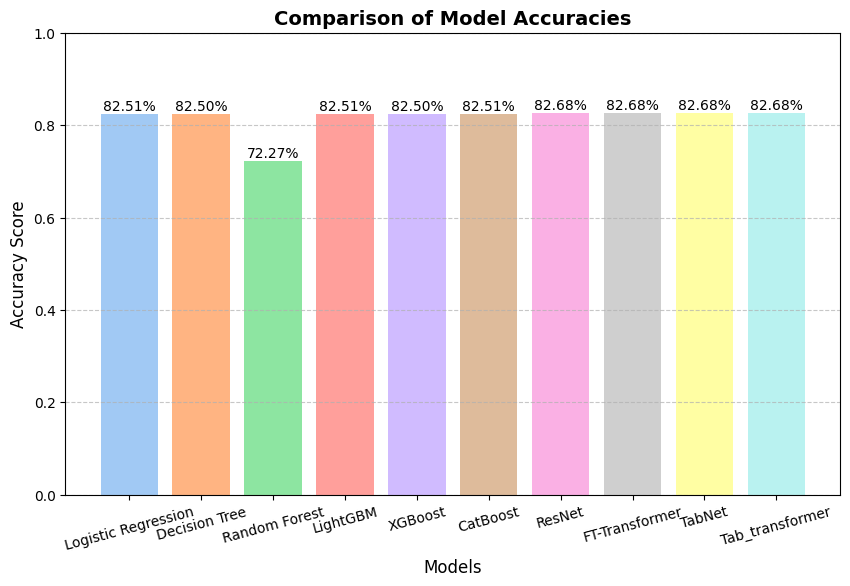

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'LightGBM', 'XGBoost', 'CatBoost', 'ResNet', 'FT-Transformer', 'TabNet', 'Tab_transformer']
accuracies = [log_acc, acc_dt, rf_acc, acc_lgb, acc_xgb, acc_cat, resnet_score, ftt_score, tabnet_score, tab_transformer_score]

colors = sns.color_palette("pastel", len(models))

plt.figure(figsize=(10, 6))

# 바 차트 그리기
bars = plt.bar(models, accuracies, color=colors,  linewidth=1.2)

plt.ylim(0, 1)

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{acc:.2%}",
             ha='center', va='bottom', fontsize=10)


plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy Score", fontsize=12)
plt.title("Comparison of Model Accuracies", fontsize=14, fontweight='bold')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()